In [1]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction

from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

This notebook does the same things as the other ML ones, but I remove some "bad users". See the code to figure out which process I am using to remove "bad users".

# Data Preparation

## Cognitive Load Info

In [2]:
path_to_experiment_info: str = "../data.nosync/usilaughs/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=1)

## Physiological Data

In [3]:
eda_data_base_path: str = "../data.nosync/usilaughs/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/usilaughs/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/67 [00:00<?, ?it/s]

604

In [4]:
users = get_all_users(eda_data)
sessions_all = ["experiment"]
output_folder: str = "../visualizations/"
for user in tqdm(sorted(users), desc="Plotting user data", colour="red"):
    for session in sessions_all:
        make_biometrics_plots_together_matplotlib(
            data={"EDA": eda_data},
            user_id=user,
            session_id=session,
            dataset="usi_laughs",
            experiment_info=experiment_info.to_df(),
            eda_type="mixed-EDA",
            output_folder=output_folder
        )


Plotting user data:   0%|          | 0/32 [00:00<?, ?it/s]

In [4]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())

In [5]:
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 32


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [6]:
segment_size_in_secs = 4
eda_sample_rate = 4

segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate
experiment_info_as_dict = experiment_info.to_dict()

In [7]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info_as_dict,
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
)


User progress:   0%|          | 0/32 [00:00<?, ?it/s]

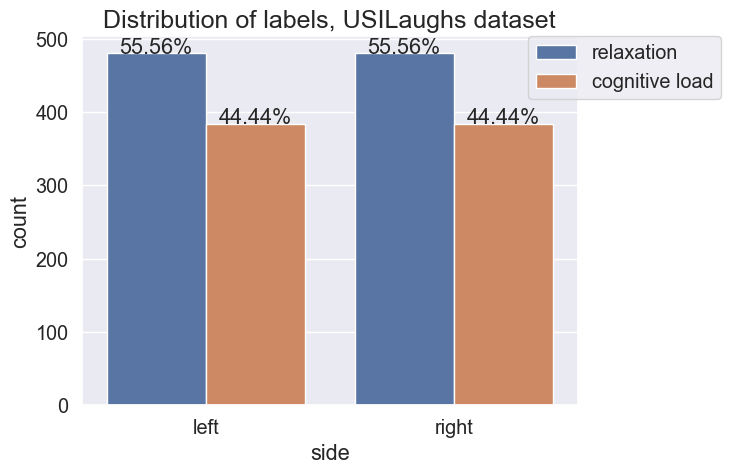

In [8]:
counts = get_labels_counts(labels_left, labels_right, ['relaxation', 'cognitive load'])
plot_binary_labels(
    counts=counts,
    title="Distribution of labels, USILaughs dataset",
    dataset_name="usilaughs",
    output_folder="../visualizations/"
)


The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Feature Extraction

In [9]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)


Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/neurokit2/eda/eda_peaks.py:130: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
Could not extract EDA peaks. Reason: zero-size array to reduction operation maximum which has no identity
/Users/leonardoalchieri/m

In [10]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)


# Bad users removal

In [11]:
# this users are bad for both the left and right. I am not removing at the moment
# users that are bad only on one side
bad_users: list[str] = ['s037', 's048', 's059', 's071', 's087', 's098']

In [16]:
from numpy import isin
features_left = features_left[isin(groups_left, bad_users, invert=True)]
features_right = features_right[isin(groups_right, bad_users, invert=True)]
labels_left = labels_left[isin(groups_left, bad_users, invert=True)]
labels_right = labels_right[isin(groups_right, bad_users, invert=True)]
groups_left = groups_left[isin(groups_left, bad_users, invert=True)]
groups_right = groups_right[isin(groups_right, bad_users, invert=True)]

# Machine Learning

## 5-fold CV (one seed)

In [11]:
model_selected: str = "RandomForestClassifier"
metrics_selected: str = "Accuracy"

#### LX v LX

In [12]:
averaged_results_cv_lxlx, all_results_cv_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)


100%|██████████| 29/29 [00:00<00:00, 42.26it/s]


In [14]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7643            0.7642  0.7642   0.7635   
ExtraTreesClassifier            0.7630            0.7629  0.7629   0.7623   
LGBMClassifier                  0.7526            0.7525  0.7525   0.7514   
XGBClassifier                   0.7396            0.7395  0.7395   0.7387   
BaggingClassifier               0.7291            0.7290  0.7290   0.7284   
LabelPropagation                0.7266            0.7265  0.7265   0.7257   
LabelSpreading                  0.7227            0.7226  0.7226   0.7216   
DecisionTreeClassifier          0.7187            0.7187  0.7187   0.7186   
KNeighborsClassifier            0.7175            0.7174  0.7174   0.7170   
AdaBoostClassifier              0.7123            0.7122  0.7122   0.7113   
NuSVC                           0.7122            0.7122  0.7122   0.7111   
SVC                             0.6979            0.6979  0.6979   0.6972   
ExtraTreeClassifier             0.6809            0.6810  0.6810   0.6803   
LogisticRegression              0.6445            0.6445  0.6445   0.6444   
CalibratedClassifierCV          0.6354            0.6354  0.6354   0.6353   
LinearSVC                       0.6354            0.6354  0.6354   0.6353   
RidgeClassifierCV               0.6354            0.6354  0.6354   0.6353   
RidgeClassifier                 0.6328            0.6327  0.6327   0.6326   
NearestCentroid                 0.6262            0.6262  0.6262   0.6260   
LinearDiscriminantAnalysis      0.6237            0.6236  0.6236   0.6234   
BernoulliNB                     0.6211            0.6211  0.6211   0.6201   
SGDClassifier                   0.6014            0.6016  0.6016   0.5982   
QuadraticDiscriminantAnalysis   0.5611            0.5613  0.5613   0.5056   
Perceptron                      0.5597            0.5601  0.5601   0.5399   
GaussianNB                      0.5482            0.5482  0.5482   0.4697   
PassiveAggressiveClassifier     0.5052            0.5057  0.5057   0.4661   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1059         0.0071            0.0071   
ExtraTreesClassifier              0.0721         0.0158            0.0159   
LGBMClassifier                    0.0330         0.0086            0.0086   
XGBClassifier                     0.0718         0.0157            0.0157   
BaggingClassifier                 0.0255         0.0140            0.0140   
LabelPropagation                  0.0074         0.0101            0.0101   
LabelSpreading                    0.0091         0.0101            0.0101   
DecisionTreeClassifier            0.0062         0.0125            0.0125   
KNeighborsClassifier              0.0056         0.0176            0.0176   
AdaBoostClassifier                0.0524         0.0200            0.0199   
NuSVC                             0.0164         0.0088            0.0088   
SVC                               0.0126         0.0123            0.0123   
ExtraTreeClassifier               0.0039         0.0170            0.0170   
LogisticRegression                0.0067         0.0087            0.0087   
CalibratedClassifierCV            0.1081         0.0113            0.0113   
LinearSVC                         0.0293         0.0102            0.0102   
RidgeClassifierCV                 0.0042         0.0125            0.0125   
RidgeClassifier                   0.0041         0.0128            0.0128   
NearestCentroid                   0.0347         0.0122            0.0122   
LinearDiscriminantAnalysis

#### RX vs RX

In [15]:
averaged_results_cv_rxrx, all_results_cv_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=1,
    n_seeds_to_test_folds=1,
)

100%|██████████| 29/29 [00:00<00:00, 45.66it/s]


In [16]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8151            0.8152  0.8152   0.8149   
BaggingClassifier               0.8099            0.8100  0.8100   0.8097   
RandomForestClassifier          0.8086            0.8087  0.8087   0.8084   
KNeighborsClassifier            0.7995            0.7995  0.7995   0.7994   
LGBMClassifier                  0.7995            0.7996  0.7996   0.7991   
XGBClassifier                   0.7956            0.7957  0.7957   0.7955   
AdaBoostClassifier              0.7761            0.7760  0.7760   0.7758   
NuSVC                           0.7748            0.7748  0.7748   0.7746   
SVC                             0.7735            0.7735  0.7735   0.7733   
DecisionTreeClassifier          0.7631            0.7632  0.7632   0.7626   
LabelSpreading                  0.7579            0.7579  0.7579   0.7572   
ExtraTreeClassifier             0.7566            0.7566  0.7566   0.7562   
LabelPropagation                0.7566            0.7566  0.7566   0.7559   
CalibratedClassifierCV          0.7057            0.7056  0.7056   0.7053   
NearestCentroid                 0.7044            0.7044  0.7044   0.7041   
BernoulliNB                     0.7018            0.7017  0.7017   0.7014   
LinearSVC                       0.6979            0.6979  0.6979   0.6975   
GaussianNB                      0.6979            0.6977  0.6977   0.6962   
LinearDiscriminantAnalysis      0.6966            0.6965  0.6965   0.6962   
LogisticRegression              0.6940            0.6940  0.6940   0.6936   
RidgeClassifier                 0.6914            0.6913  0.6913   0.6909   
RidgeClassifierCV               0.6901            0.6900  0.6900   0.6895   
QuadraticDiscriminantAnalysis   0.6510            0.6511  0.6511   0.6441   
Perceptron                      0.6392            0.6399  0.6399   0.6230   
SGDClassifier                   0.6381            0.6378  0.6378   0.6301   
PassiveAggressiveClassifier     0.5353            0.5352  0.5352   0.5219   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0687         0.0055            0.0055   
BaggingClassifier                 0.0248         0.0093            0.0093   
RandomForestClassifier            0.1050         0.0050            0.0049   
KNeighborsClassifier              0.0054         0.0090            0.0090   
LGBMClassifier                    0.0340         0.0107            0.0107   
XGBClassifier                     0.0678         0.0092            0.0092   
AdaBoostClassifier                0.0539         0.0062            0.0062   
NuSVC                             0.0126         0.0096            0.0096   
SVC                               0.0108         0.0085            0.0085   
DecisionTreeClassifier            0.0063         0.0217            0.0217   
LabelSpreading                    0.0093         0.0193            0.0192   
ExtraTreeClassifier               0.0038         0.0201            0.0201   
LabelPropagation                  0.0072         0.0186            0.0186   
CalibratedClassifierCV            0.1107         0.0137            0.0136   
NearestCentroid                   0.0129         0.0141            0.0140   
BernoulliNB                       0.0037         0.0119            0.0118   
LinearSVC                         0.0292         0.0111            0.0111   
GaussianNB                        0.0036         0.0167            0.0167   
LinearDiscriminantAnalysis        0.0042         0.0131            0.0131   
LogisticRegression        

#### Visualizing differences

In [17]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_lxlx
    for single_result in seed_res
]

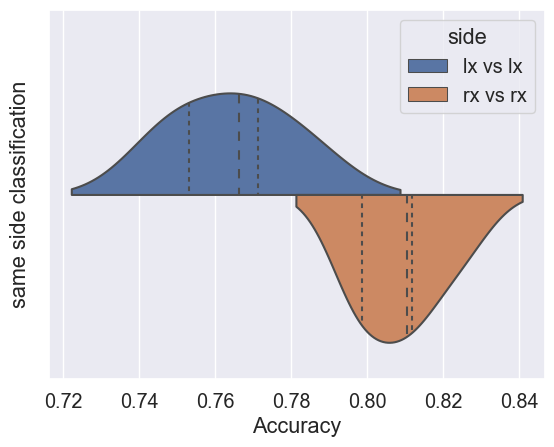

In [18]:
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile')
# ax.set_ylim(0.5, 1.0)

#### LX vs RX

In [19]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
models_lxrx, _ = clf.fit(x_resampled_lx, x_resampled_rx, y_resampled_lx, y_resampled_rx)

100%|██████████| 29/29 [00:01<00:00, 20.20it/s]


In [17]:
models_lxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.77,0.77,0.77,0.77,0.12
SVC,0.76,0.76,0.76,0.76,0.03
KNeighborsClassifier,0.76,0.76,0.76,0.75,0.01
ExtraTreesClassifier,0.75,0.75,0.75,0.75,0.08
AdaBoostClassifier,0.74,0.74,0.74,0.74,0.06
LGBMClassifier,0.73,0.73,0.73,0.73,0.38
LabelSpreading,0.73,0.73,0.73,0.73,0.02
NuSVC,0.73,0.73,0.73,0.73,0.03
LabelPropagation,0.73,0.73,0.73,0.73,0.02


#### RX vs LX

In [18]:
clf = LazyClassifier(predictions=True, random_state=42)

x_resampled_rx, y_resampled_rx, _ = local_resampling(features_right, labels_right, groups_right)
x_resampled_lx, y_resampled_lx, _ = local_resampling(features_left, labels_left, groups_left)
models_rxrx, predictions = clf.fit(x_resampled_rx, x_resampled_lx, y_resampled_rx, y_resampled_lx)

100%|██████████| 29/29 [00:01<00:00, 27.39it/s]


In [19]:
models_rxrx.sort_values(by="Balanced Accuracy", ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.71,0.71,0.71,0.71,0.01
RandomForestClassifier,0.71,0.71,0.71,0.71,0.12
BaggingClassifier,0.71,0.71,0.71,0.71,0.03
LabelPropagation,0.71,0.71,0.71,0.71,0.03
LabelSpreading,0.71,0.71,0.71,0.71,0.02
ExtraTreesClassifier,0.70,0.70,0.70,0.70,0.08
LGBMClassifier,0.70,0.70,0.70,0.70,0.38
XGBClassifier,0.70,0.70,0.70,0.70,0.05
NuSVC,0.70,0.70,0.70,0.70,0.02


## 5-fold CV - different seeds

### LX vs LX

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [20]:
averaged_results_cv_multi_lxlx, all_results_cv_multi_lxlx = run_cross_validation_prediction(
    x=features_left,
    y=labels_left,
    groups=groups_left,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.38it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.24it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.23it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.62it/s]

100%|██████████| 29/29 [00:00<00:00, 46.54it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.70it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.61it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.51it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.51it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.23it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.24it/s]


In [21]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.7653            0.7652  0.7652   0.7648   
RandomForestClassifier          0.7592            0.7591  0.7591   0.7587   
LGBMClassifier                  0.7504            0.7504  0.7504   0.7500   
XGBClassifier                   0.7410            0.7410  0.7410   0.7405   
BaggingClassifier               0.7401            0.7401  0.7401   0.7395   
AdaBoostClassifier              0.7192            0.7192  0.7192   0.7185   
LabelSpreading                  0.7185            0.7185  0.7185   0.7179   
LabelPropagation                0.7178            0.7178  0.7178   0.7173   
KNeighborsClassifier            0.7177            0.7177  0.7177   0.7173   
NuSVC                           0.7101            0.7101  0.7101   0.7093   
DecisionTreeClassifier          0.7074            0.7074  0.7074   0.7069   
SVC                             0.6958            0.6958  0.6958   0.6953   
ExtraTreeClassifier             0.6867            0.6867  0.6867   0.6862   
LogisticRegression              0.6376            0.6376  0.6376   0.6369   
CalibratedClassifierCV          0.6373            0.6373  0.6373   0.6367   
RidgeClassifierCV               0.6345            0.6344  0.6344   0.6338   
LinearSVC                       0.6324            0.6324  0.6324   0.6317   
RidgeClassifier                 0.6299            0.6299  0.6299   0.6293   
LinearDiscriminantAnalysis      0.6271            0.6270  0.6270   0.6264   
NearestCentroid                 0.6253            0.6253  0.6253   0.6246   
BernoulliNB                     0.6216            0.6216  0.6216   0.6198   
SGDClassifier                   0.5810            0.5810  0.5810   0.5656   
Perceptron                      0.5598            0.5598  0.5598   0.5439   
PassiveAggressiveClassifier     0.5592            0.5591  0.5591   0.5314   
GaussianNB                      0.5463            0.5463  0.5463   0.4666   
QuadraticDiscriminantAnalysis   0.5456            0.5456  0.5456   0.4860   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0714         0.0014            0.0014   
RandomForestClassifier            0.1058         0.0013            0.0013   
LGBMClassifier                    0.0331         0.0012            0.0012   
XGBClassifier                     0.0714         0.0013            0.0013   
BaggingClassifier                 0.0257         0.0015            0.0015   
AdaBoostClassifier                0.0521         0.0018            0.0018   
LabelSpreading                    0.0095         0.0014            0.0014   
LabelPropagation                  0.0074         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
NuSVC                             0.0160         0.0012            0.0012   
DecisionTreeClassifier            0.0063         0.0017            0.0017   
SVC                               0.0126         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0018            0.0018   
LogisticRegression                0.0061         0.0020            0.0020   
CalibratedClassifierCV            0.1100         0.0021            0.0021   
RidgeClassifierCV                 0.0045         0.0019            0.0019   
LinearSVC                         0.0293         0.0019            0.0019   
RidgeClassifier                   0.0043         0.0019            0.0019   
LinearDiscriminantAnalysis        0.0041         0.0019            0.0019   
NearestCentroid           

### RX vs RX

In [22]:
averaged_results_cv_multi_rxrx, all_results_cv_multi_rxrx = run_cross_validation_prediction(
    x=features_right,
    y=labels_right,
    groups=groups_right,
    generator_seeds=[42, 666],
    n_seeds_to_test_classifiers=10,
    n_seeds_to_test_folds=10,
)

Random states folds progress::   0%|          | 0/10 [00:00<?, ?it/s]

Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.92it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.62it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.59it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.15it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.53it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.75it/s]

100%|██████████| 29/29 [00:00<00:00, 47.56it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.36it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.06it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.78it/s]


Random states classifiers progress::   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.78it/s]

100%|██████████| 29/29 [00:00<00:00, 47.81it/s]


In [23]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_cv_multi_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8144            0.8144  0.8144   0.8141   
RandomForestClassifier          0.8134            0.8134  0.8134   0.8132   
LGBMClassifier                  0.8083            0.8083  0.8083   0.8081   
XGBClassifier                   0.8064            0.8064  0.8064   0.8062   
BaggingClassifier               0.7993            0.7993  0.7993   0.7989   
KNeighborsClassifier            0.7829            0.7829  0.7829   0.7827   
AdaBoostClassifier              0.7738            0.7738  0.7738   0.7735   
NuSVC                           0.7703            0.7703  0.7703   0.7699   
SVC                             0.7663            0.7663  0.7663   0.7659   
DecisionTreeClassifier          0.7624            0.7624  0.7624   0.7620   
LabelSpreading                  0.7592            0.7593  0.7593   0.7587   
LabelPropagation                0.7569            0.7569  0.7569   0.7564   
ExtraTreeClassifier             0.7427            0.7427  0.7427   0.7423   
CalibratedClassifierCV          0.7047            0.7047  0.7047   0.7040   
NearestCentroid                 0.7010            0.7010  0.7010   0.7004   
BernoulliNB                     0.6989            0.6989  0.6989   0.6982   
LinearDiscriminantAnalysis      0.6966            0.6966  0.6966   0.6961   
GaussianNB                      0.6961            0.6960  0.6960   0.6934   
LinearSVC                       0.6915            0.6914  0.6914   0.6908   
RidgeClassifierCV               0.6914            0.6914  0.6914   0.6908   
LogisticRegression              0.6914            0.6914  0.6914   0.6908   
RidgeClassifier                 0.6907            0.6907  0.6907   0.6901   
SGDClassifier                   0.6372            0.6372  0.6372   0.6294   
Perceptron                      0.6114            0.6114  0.6114   0.6019   
PassiveAggressiveClassifier     0.6103            0.6103  0.6103   0.5937   
QuadraticDiscriminantAnalysis   0.6094            0.6094  0.6094   0.5855   
DummyClassifier                 0.4987            0.5000  0.5000   0.3319   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0681         0.0012            0.0012   
RandomForestClassifier            0.1022         0.0014            0.0014   
LGBMClassifier                    0.0342         0.0014            0.0014   
XGBClassifier                     0.0682         0.0013            0.0013   
BaggingClassifier                 0.0248         0.0014            0.0014   
KNeighborsClassifier              0.0057         0.0015            0.0015   
AdaBoostClassifier                0.0522         0.0013            0.0013   
NuSVC                             0.0123         0.0017            0.0017   
SVC                               0.0109         0.0016            0.0016   
DecisionTreeClassifier            0.0064         0.0015            0.0015   
LabelSpreading                    0.0097         0.0015            0.0015   
LabelPropagation                  0.0074         0.0016            0.0016   
ExtraTreeClassifier               0.0040         0.0017            0.0017   
CalibratedClassifierCV            0.1114         0.0017            0.0017   
NearestCentroid                   0.0039         0.0017            0.0017   
BernoulliNB                       0.0039         0.0017            0.0017   
LinearDiscriminantAnalysis        0.0041         0.0016            0.0016   
GaussianNB                        0.0038         0.0021            0.0021   
LinearSVC                         0.0293         0.0016            0.0016   
RidgeClassifierCV         

#### Visualizing results

In [26]:
selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_cv_multi_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_cv_multi_lxlx
    for single_result in seed_res
]

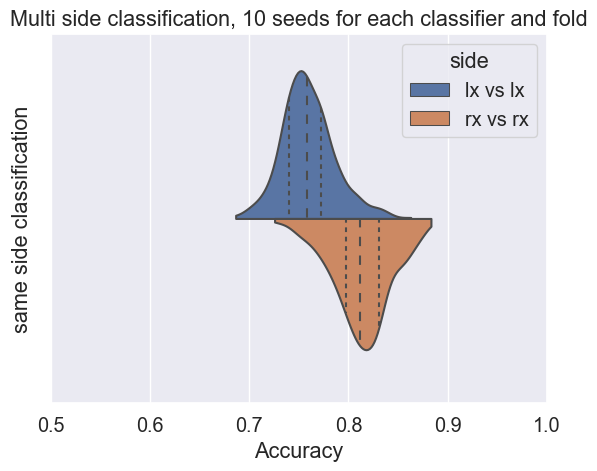

In [32]:
import matplotlib.pyplot as plt
from seaborn import violinplot

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title("Multi side classification, 10 seeds for each classifier and fold")
ax.set_xlim(0.5, 1.0)
plt.show()

## LOSO

In [19]:
model_selected: str = "RandomForestClassifier"
metrics_selected: str = 'Accuracy'
n_seeds_to_test_classifiers: int = 30

### Test with different seeds (LX vs LX)

The idea here is to run the same algorithms, but with different seeds. This allows to get an accuracy result which is averaged over different starting conditions. This should allow for the reported accuracy to be more robust to stochastic variations.

In [20]:
averaged_results_loso_lxlx, all_results_loso_lxlx = run_same_side_classifications(
    features_left, labels_left, groups_left, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers, n_jobs=-1
)


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 47.82it/s]


In [22]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.7418            0.7418  0.7418   0.7155   
NuSVC                           0.7404            0.7404  0.7404   0.7121   
SVC                             0.7356            0.7356  0.7356   0.7073   
ExtraTreesClassifier            0.7355            0.7355  0.7355   0.7121   
KNeighborsClassifier            0.7276            0.7276  0.7276   0.7015   
BaggingClassifier               0.7163            0.7163  0.7163   0.6945   
LabelSpreading                  0.7051            0.7051  0.7051   0.6832   
LGBMClassifier                  0.7019            0.7019  0.7019   0.6740   
LabelPropagation                0.7003            0.7003  0.7003   0.6788   
AdaBoostClassifier              0.7001            0.7001  0.7001   0.6764   
XGBClassifier                   0.6939            0.6939  0.6939   0.6696   
CalibratedClassifierCV          0.6779            0.6779  0.6779   0.6522   
RidgeClassifier                 0.6763            0.6763  0.6763   0.6510   
LinearSVC                       0.6752            0.6752  0.6752   0.6499   
BernoulliNB                     0.6747            0.6747  0.6747   0.6518   
RidgeClassifierCV               0.6731            0.6731  0.6731   0.6477   
LinearDiscriminantAnalysis      0.6731            0.6731  0.6731   0.6466   
LogisticRegression              0.6715            0.6715  0.6715   0.6452   
DecisionTreeClassifier          0.6693            0.6693  0.6693   0.6502   
ExtraTreeClassifier             0.6646            0.6646  0.6646   0.6465   
NearestCentroid                 0.6587            0.6587  0.6587   0.6335   
PassiveAggressiveClassifier     0.6041            0.6041  0.6041   0.5584   
SGDClassifier                   0.6012            0.6012  0.6012   0.5623   
Perceptron                      0.5833            0.5833  0.5833   0.5408   
GaussianNB                      0.5545            0.5545  0.5545   0.4331   
QuadraticDiscriminantAnalysis   0.5433            0.5433  0.5433   0.4330   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1303         0.0179            0.0179   
NuSVC                             0.0134         0.0184            0.0184   
SVC                               0.0115         0.0199            0.0199   
ExtraTreesClassifier              0.0876         0.0165            0.0165   
KNeighborsClassifier              0.0052         0.0156            0.0156   
BaggingClassifier                 0.0325         0.0175            0.0175   
LabelSpreading                    0.0109         0.0172            0.0172   
LGBMClassifier                    0.0404         0.0183            0.0183   
LabelPropagation                  0.0085         0.0172            0.0172   
AdaBoostClassifier                0.0675         0.0195            0.0195   
XGBClassifier                     0.0832         0.0179            0.0179   
CalibratedClassifierCV            0.1347         0.0279            0.0279   
RidgeClassifier                   0.0054         0.0280            0.0280   
LinearSVC                         0.0355         0.0281            0.0281   
BernoulliNB                       0.0050         0.0268            0.0268   
RidgeClassifierCV                 0.0053         0.0282            0.0282   
LinearDiscriminantAnalysis        0.0053         0.0275            0.0275   
LogisticRegression                0.0087         0.0280            0.0280   
DecisionTreeClassifier            0.0084         0.0154            0.0154   
ExtraTreeClassifier       

### Test with different seeds (RX vs RX)

In [23]:
averaged_results_loso_rxrx, all_results_loso_rxrx = run_same_side_classifications(
    features_right, labels_right, groups_right, n_seeds_to_test_classifiers=n_seeds_to_test_classifiers
)


Random states classifiers progress::   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 46.60it/s]


In [24]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
RandomForestClassifier          0.8362            0.8362  0.8362   0.8292   
LGBMClassifier                  0.8333            0.8333  0.8333   0.8243   
KNeighborsClassifier            0.8333            0.8333  0.8333   0.8234   
ExtraTreesClassifier            0.8297            0.8297  0.8297   0.8222   
BaggingClassifier               0.8294            0.8294  0.8294   0.8219   
XGBClassifier                   0.8285            0.8285  0.8285   0.8218   
DecisionTreeClassifier          0.8231            0.8231  0.8231   0.8154   
AdaBoostClassifier              0.8093            0.8093  0.8093   0.7966   
SVC                             0.8045            0.8045  0.8045   0.7933   
NuSVC                           0.8029            0.8029  0.8029   0.7841   
LabelSpreading                  0.7756            0.7756  0.7756   0.7693   
LabelPropagation                0.7692            0.7692  0.7692   0.7628   
BernoulliNB                     0.7612            0.7612  0.7612   0.7387   
ExtraTreeClassifier             0.7494            0.7494  0.7494   0.7392   
CalibratedClassifierCV          0.7452            0.7452  0.7452   0.7284   
LinearDiscriminantAnalysis      0.7404            0.7404  0.7404   0.7239   
LinearSVC                       0.7343            0.7343  0.7343   0.7179   
RidgeClassifier                 0.7340            0.7340  0.7340   0.7172   
RidgeClassifierCV               0.7340            0.7340  0.7340   0.7170   
LogisticRegression              0.7324            0.7324  0.7324   0.7142   
NearestCentroid                 0.7292            0.7292  0.7292   0.7179   
GaussianNB                      0.7051            0.7051  0.7051   0.6973   
SGDClassifier                   0.6630            0.6630  0.6630   0.6359   
PassiveAggressiveClassifier     0.6554            0.6554  0.6554   0.6174   
Perceptron                      0.6439            0.6439  0.6439   0.6124   
QuadraticDiscriminantAnalysis   0.6122            0.6122  0.6122   0.5505   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
RandomForestClassifier            0.1193         0.0123            0.0123   
LGBMClassifier                    0.0413         0.0110            0.0110   
KNeighborsClassifier              0.0049         0.0122            0.0122   
ExtraTreesClassifier              0.0780         0.0113            0.0113   
BaggingClassifier                 0.0293         0.0127            0.0127   
XGBClassifier                     0.0736         0.0116            0.0116   
DecisionTreeClassifier            0.0074         0.0112            0.0112   
AdaBoostClassifier                0.0639         0.0162            0.0162   
SVC                               0.0099         0.0171            0.0171   
NuSVC                             0.0121         0.0175            0.0175   
LabelSpreading                    0.0102         0.0131            0.0131   
LabelPropagation                  0.0077         0.0133            0.0133   
BernoulliNB                       0.0047         0.0254            0.0254   
ExtraTreeClassifier               0.0047         0.0133            0.0133   
CalibratedClassifierCV            0.1300         0.0243            0.0243   
LinearDiscriminantAnalysis        0.0049         0.0247            0.0247   
LinearSVC                         0.0348         0.0248            0.0248   
RidgeClassifier                   0.0050         0.0249            0.0249   
RidgeClassifierCV                 0.0052         0.0250            0.0250   
LogisticRegression        

### Visualizing results (same side)

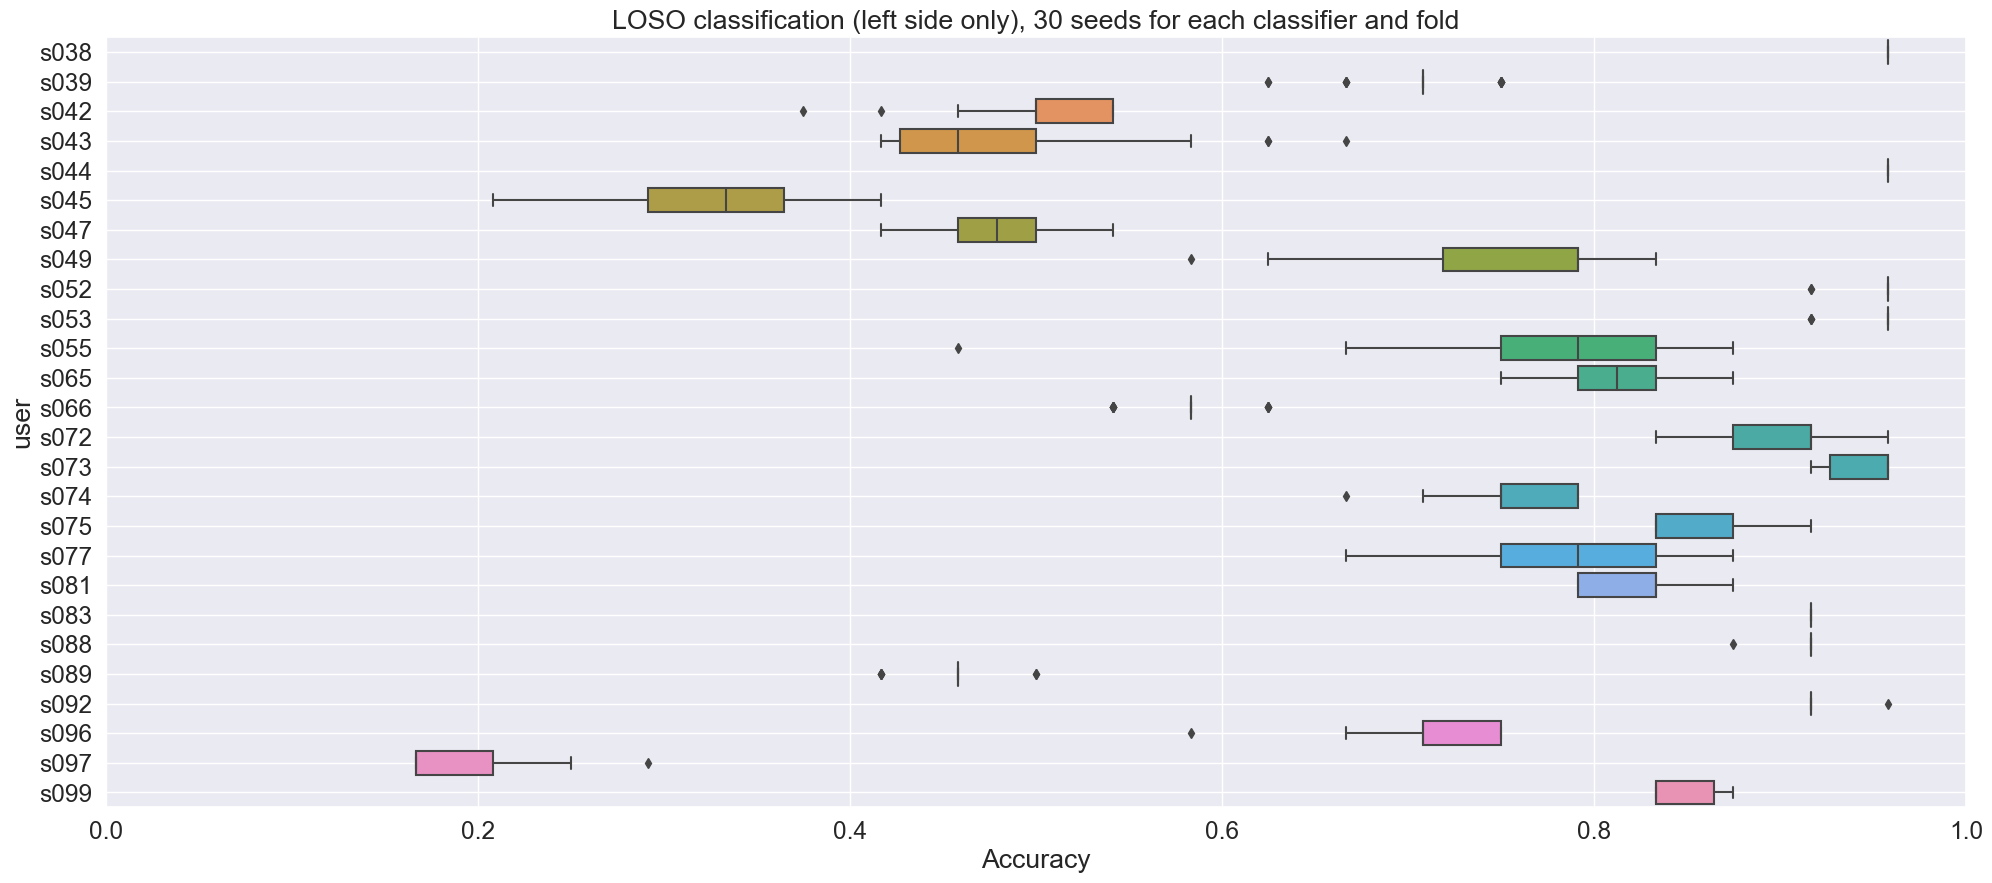

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (left side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


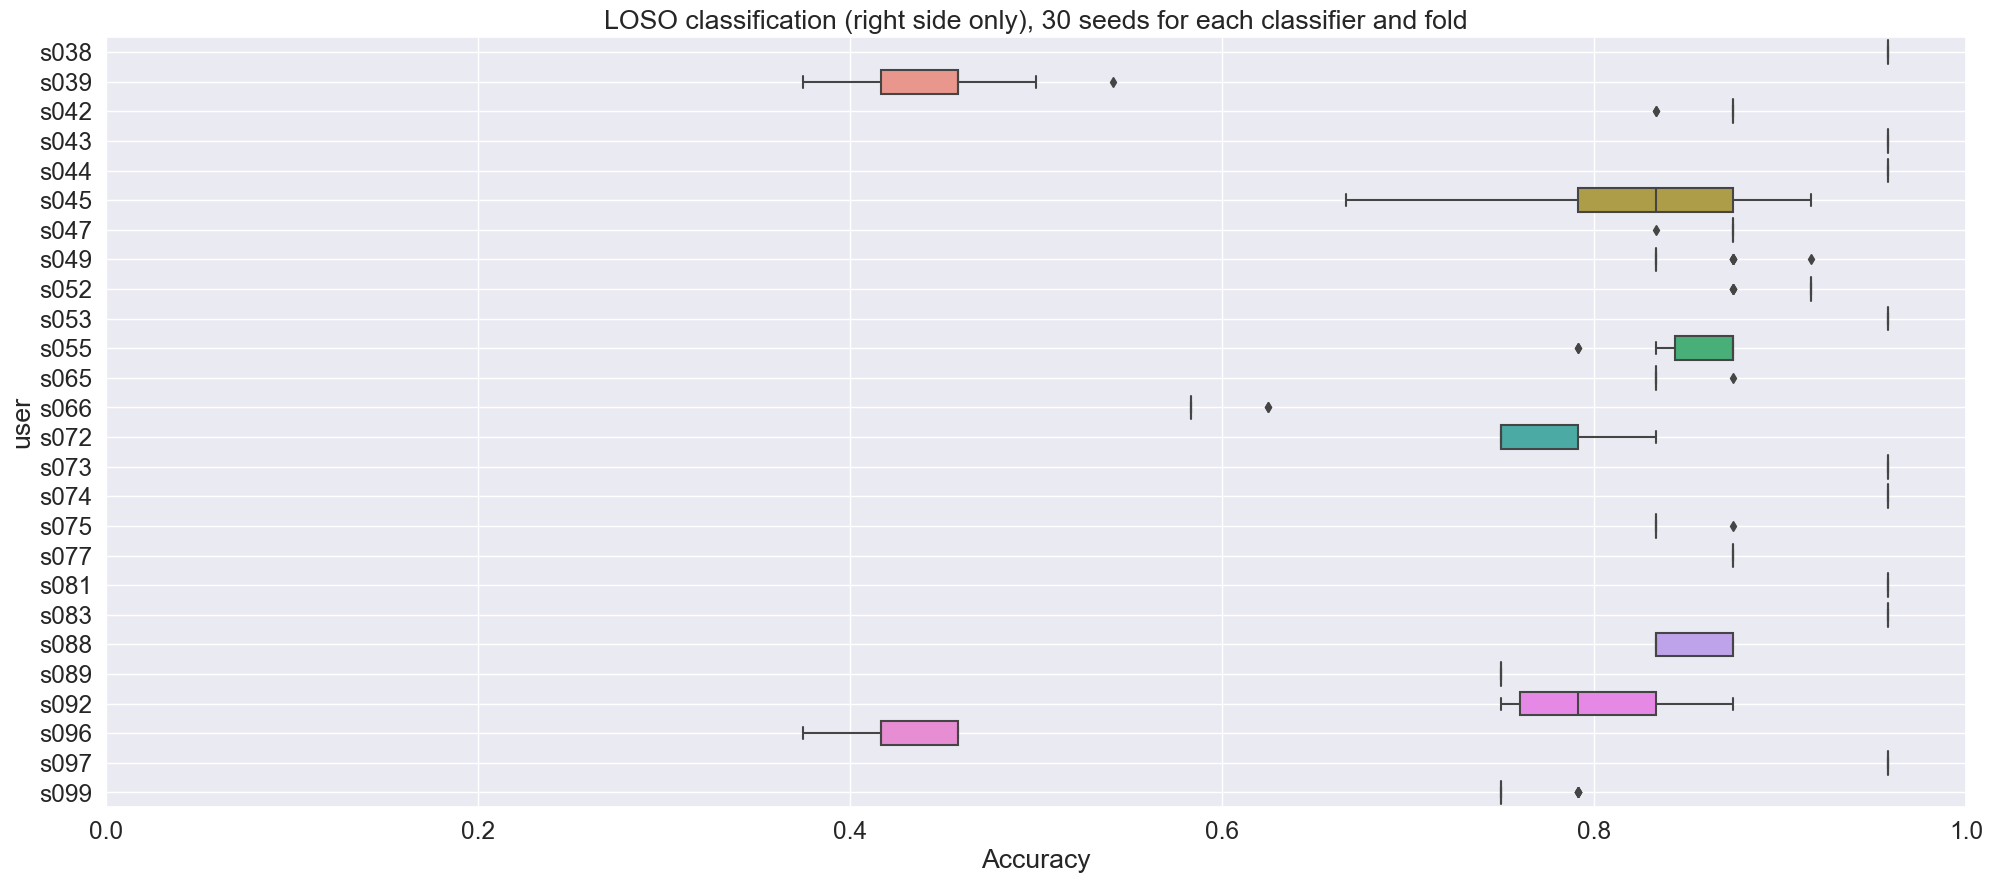

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

plt.figure(figsize=(24, 10))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user")
ax.xaxis.grid(True)
ax.yaxis.grid(True)
plt.title(f"LOSO classification (right side only), {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0)
plt.show()


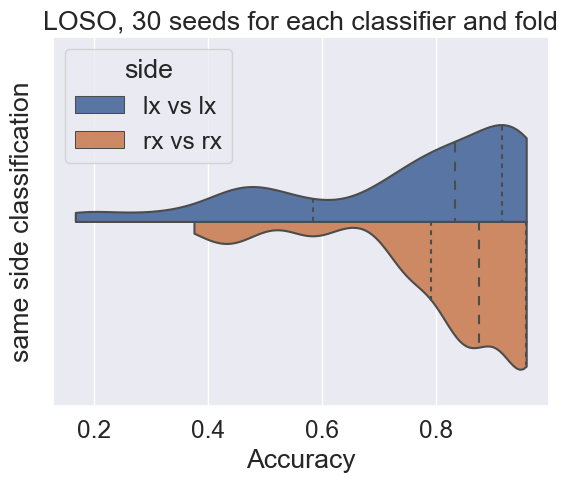

In [27]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "rx vs rx")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "lx vs lx")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

extra_col_name: str = 'same side classification'
data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx], columns=[metrics_selected, "side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
# ax.set_xlim(0.5, 1.0)
plt.show()

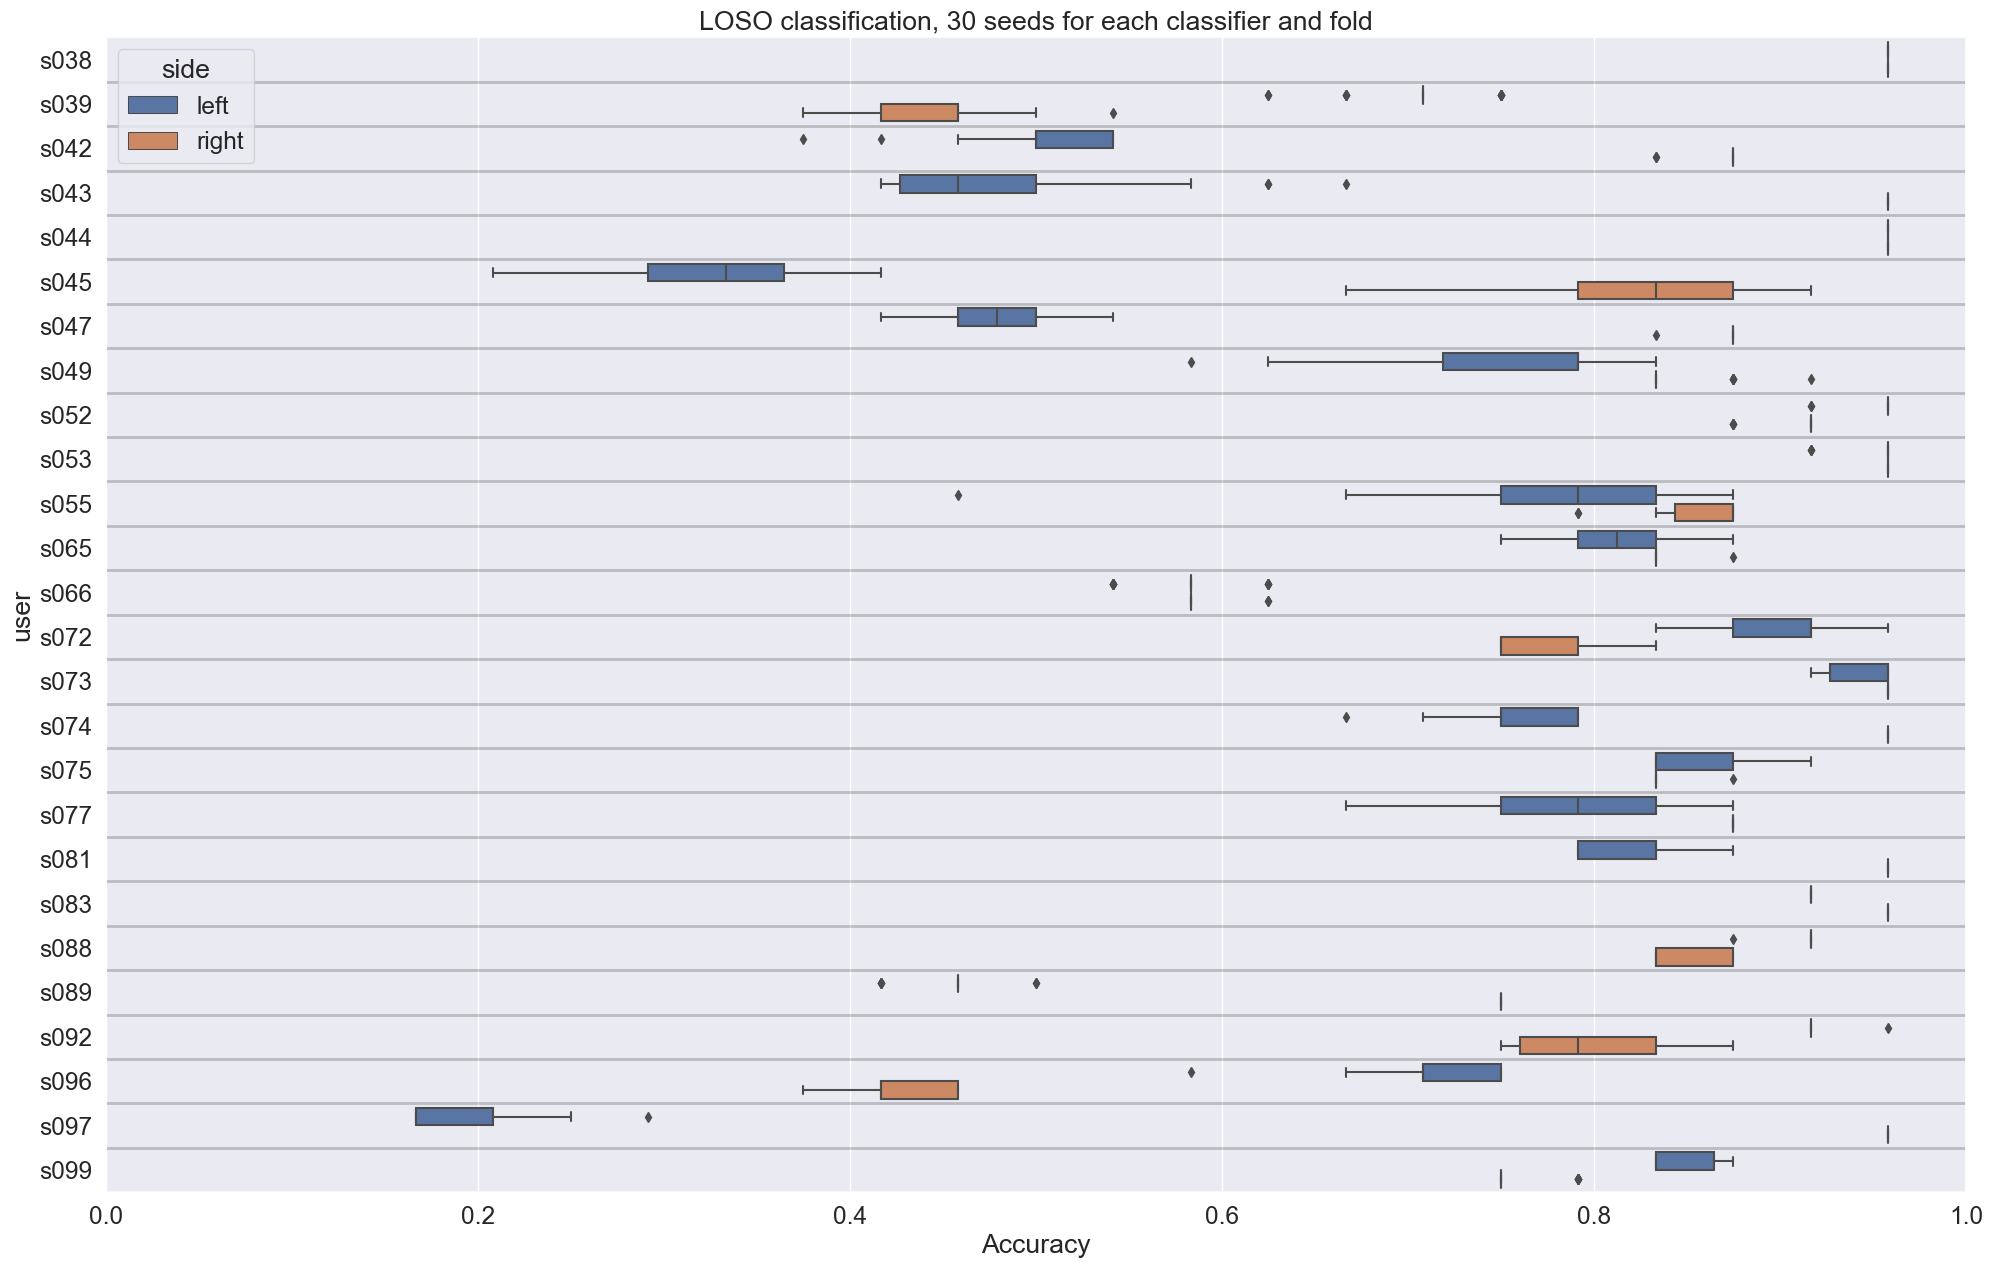

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_rxrx, *selected_results_lxlx], columns=[metrics_selected, "side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


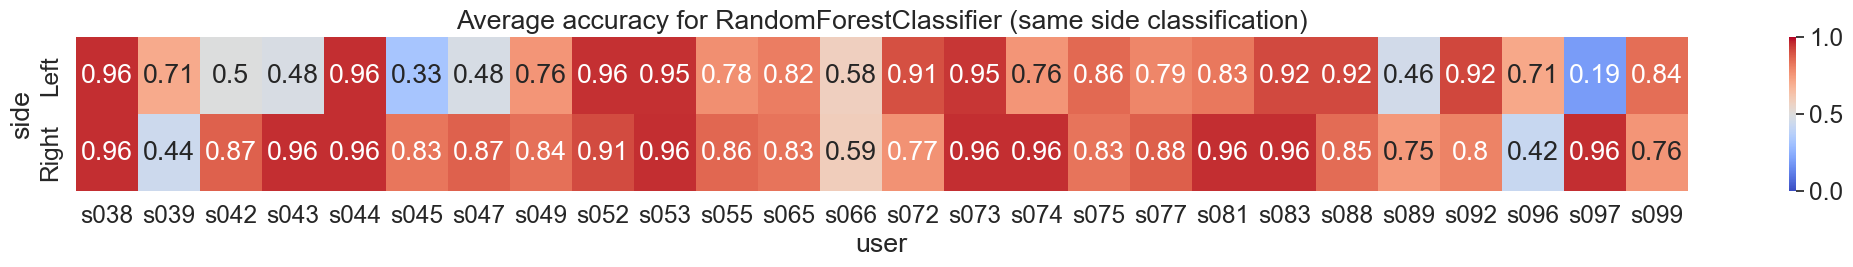

In [29]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (same side classification)")
plt.show()

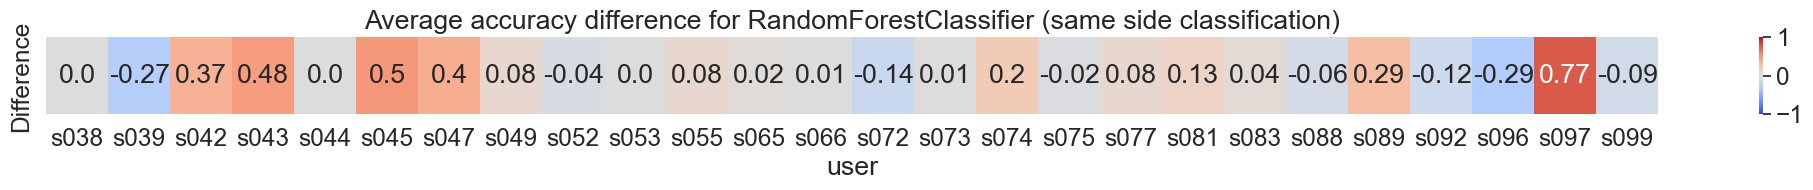

In [30]:
data_to_plot2 = data_to_plot.groupby(['user', 'side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (same side classification)")
plt.show()

Here is it noted that the distribution of labels across each individual is the same as the total, since the duration of the experiment was them same. It is also noted that a per-user undersampling is performed.

In [25]:
# from pandas import Series 

# selected_user: str = "s077"
# left_data_mask: ndarray = groups_left == selected_user
# current_labels_left = labels_left[left_data_mask]
# right_data_mask: ndarray = groups_right == selected_user
# current_labels_right = labels_right[right_data_mask]

# counts = {
#     "left": Series(current_labels_left).value_counts(),
#     "right": Series(current_labels_right).value_counts(),
# }
# counts = DataFrame(counts).unstack().reset_index()
# counts.columns = ["side", "label", "count"]
# counts["label"] = counts["label"].map({0: "relaxation", 1: "cognitive load"})
# plot_binary_labels(
#     counts=counts,
#     title=f"Distribution of labels, USILaughs dataset, user {selected_user}",
#     dataset_name=f"usilaughs_{selected_user}",
#     output_folder="../visualizations/"
# )


### Test with different seeds (LX vs RX)

In [31]:
averaged_results_loso_lxrx, all_results_loso_lxrx = run_different_classifications(
    x_train=features_left,
    x_test=features_right,
    y_train=labels_left,
    y_test=labels_right,
    folds_train=groups_left,
    folds_test=groups_right,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
    n_jobs=-1,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 48.25it/s]


In [32]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_lxrx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
ExtraTreesClassifier            0.8241            0.8241  0.8241   0.8132   
RandomForestClassifier          0.8200            0.8200  0.8200   0.8084   
NuSVC                           0.8189            0.8189  0.8189   0.8039   
SVC                             0.8125            0.8125  0.8125   0.7981   
BaggingClassifier               0.8011            0.8011  0.8011   0.7920   
XGBClassifier                   0.7981            0.7981  0.7981   0.7902   
KNeighborsClassifier            0.7981            0.7981  0.7981   0.7908   
LGBMClassifier                  0.7965            0.7965  0.7965   0.7828   
LabelSpreading                  0.7933            0.7933  0.7933   0.7866   
LabelPropagation                0.7901            0.7901  0.7901   0.7837   
AdaBoostClassifier              0.7740            0.7740  0.7740   0.7637   
CalibratedClassifierCV          0.7532            0.7532  0.7532   0.7276   
RidgeClassifier                 0.7436            0.7436  0.7436   0.7252   
LinearSVC                       0.7432            0.7432  0.7432   0.7223   
LogisticRegression              0.7420            0.7420  0.7420   0.7203   
RidgeClassifierCV               0.7420            0.7420  0.7420   0.7227   
LinearDiscriminantAnalysis      0.7404            0.7404  0.7404   0.7221   
BernoulliNB                     0.7372            0.7372  0.7372   0.7227   
DecisionTreeClassifier          0.7263            0.7263  0.7263   0.7174   
ExtraTreeClassifier             0.7162            0.7162  0.7162   0.7058   
NearestCentroid                 0.7099            0.7099  0.7099   0.6975   
PassiveAggressiveClassifier     0.6362            0.6362  0.6362   0.5932   
SGDClassifier                   0.6356            0.6356  0.6356   0.5964   
Perceptron                      0.6104            0.6104  0.6104   0.5726   
GaussianNB                      0.5369            0.5369  0.5369   0.4224   
QuadraticDiscriminantAnalysis   0.5224            0.5224  0.5224   0.4242   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
ExtraTreesClassifier              0.0826         0.0124            0.0124   
RandomForestClassifier            0.1253         0.0121            0.0121   
NuSVC                             0.0126         0.0157            0.0157   
SVC                               0.0112         0.0168            0.0168   
BaggingClassifier                 0.0306         0.0137            0.0137   
XGBClassifier                     0.0807         0.0146            0.0146   
KNeighborsClassifier              0.0048         0.0135            0.0135   
LGBMClassifier                    0.0390         0.0146            0.0146   
LabelSpreading                    0.0102         0.0124            0.0124   
LabelPropagation                  0.0079         0.0128            0.0128   
AdaBoostClassifier                0.0635         0.0163            0.0163   
CalibratedClassifierCV            0.1270         0.0241            0.0241   
RidgeClassifier                   0.0050         0.0258            0.0258   
LinearSVC                         0.0336         0.0255            0.0255   
LogisticRegression                0.0075         0.0256            0.0256   
RidgeClassifierCV                 0.0053         0.0259            0.0259   
LinearDiscriminantAnalysis        0.0048         0.0257            0.0257   
BernoulliNB                       0.0046         0.0249            0.0249   
DecisionTreeClassifier            0.0078         0.0143            0.0143   
ExtraTreeClassifier       

### Test with different seeds (RX vs LX)

In [33]:
averaged_results_loso_rxlx, all_results_loso_rxlx = run_different_classifications(
    x_train=features_right,
    x_test=features_left,
    y_train=labels_right,
    y_test=labels_left,
    folds_train=groups_right,
    folds_test=groups_left,
    n_jobs=6,
    n_seeds_to_test_classifiers=n_seeds_to_test_classifiers,
)

Random states classifiers progress:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 49.45it/s]

100%|██████████| 29/29 [00:00<00:00, 50.54it/s]


In [38]:
with pandas_option_context('display.float_format', '{:0.4f}'.format):
    display(averaged_results_loso_rxlx)

Average                                     \
                              Accuracy Balanced Accuracy ROC AUC F1 Score   
Model                                                                       
KNeighborsClassifier            0.7821            0.7821  0.7821   0.7680   
LGBMClassifier                  0.7612            0.7612  0.7612   0.7435   
LabelSpreading                  0.7516            0.7516  0.7516   0.7394   
LabelPropagation                0.7500            0.7500  0.7500   0.7381   
XGBClassifier                   0.7468            0.7468  0.7468   0.7256   
ExtraTreesClassifier            0.7448            0.7448  0.7448   0.7246   
AdaBoostClassifier              0.7404            0.7404  0.7404   0.7189   
BaggingClassifier               0.7404            0.7404  0.7404   0.7194   
RandomForestClassifier          0.7400            0.7400  0.7400   0.7135   
SVC                             0.7372            0.7372  0.7372   0.7055   
NuSVC                           0.7260            0.7260  0.7260   0.6952   
BernoulliNB                     0.7147            0.7147  0.7147   0.6875   
DecisionTreeClassifier          0.7132            0.7132  0.7132   0.6945   
ExtraTreeClassifier             0.7117            0.7117  0.7117   0.6961   
GaussianNB                      0.6987            0.6987  0.6987   0.6653   
CalibratedClassifierCV          0.6907            0.6907  0.6907   0.6669   
NearestCentroid                 0.6827            0.6827  0.6827   0.6588   
LinearDiscriminantAnalysis      0.6779            0.6779  0.6779   0.6573   
LinearSVC                       0.6764            0.6764  0.6764   0.6572   
RidgeClassifier                 0.6763            0.6763  0.6763   0.6526   
RidgeClassifierCV               0.6763            0.6763  0.6763   0.6526   
LogisticRegression              0.6651            0.6651  0.6651   0.6461   
SGDClassifier                   0.6277            0.6277  0.6277   0.5985   
PassiveAggressiveClassifier     0.6254            0.6254  0.6254   0.5875   
Perceptron                      0.6157            0.6157  0.6157   0.5837   
QuadraticDiscriminantAnalysis   0.6106            0.6106  0.6106   0.5512   
DummyClassifier                 0.5000            0.5000  0.5000   0.3333   

                                         Standard error                    \
                              Time Taken       Accuracy Balanced Accuracy   
Model                                                                       
KNeighborsClassifier              0.0041         0.0168            0.0168   
LGBMClassifier                    0.0354         0.0203            0.0203   
LabelSpreading                    0.0087         0.0186            0.0186   
LabelPropagation                  0.0067         0.0185            0.0185   
XGBClassifier                     0.0613         0.0209            0.0209   
ExtraTreesClassifier              0.0642         0.0213            0.0213   
AdaBoostClassifier                0.0525         0.0232            0.0232   
BaggingClassifier                 0.0238         0.0209            0.0209   
RandomForestClassifier            0.0992         0.0221            0.0221   
SVC                               0.0081         0.0225            0.0225   
NuSVC                             0.0100         0.0224            0.0224   
BernoulliNB                       0.0039         0.0282            0.0282   
DecisionTreeClassifier            0.0061         0.0196            0.0196   
ExtraTreeClassifier               0.0038         0.0184            0.0184   
GaussianNB                        0.0038         0.0228            0.0228   
CalibratedClassifierCV            0.1099         0.0243            0.0243   
NearestCentroid                   0.0039         0.0283            0.0283   
LinearDiscriminantAnalysis        0.0042         0.0257            0.0257   
LinearSVC                         0.0289         0.0256            0.0256   
RidgeClassifier           

These results suggest that the test set is the one having the greater importance in the performance of "different sides classifier". However, it is unclear if this is due actual lateralization effect, or due to other factors in play, e.g., artefacts.

### Visualizing results (different side)

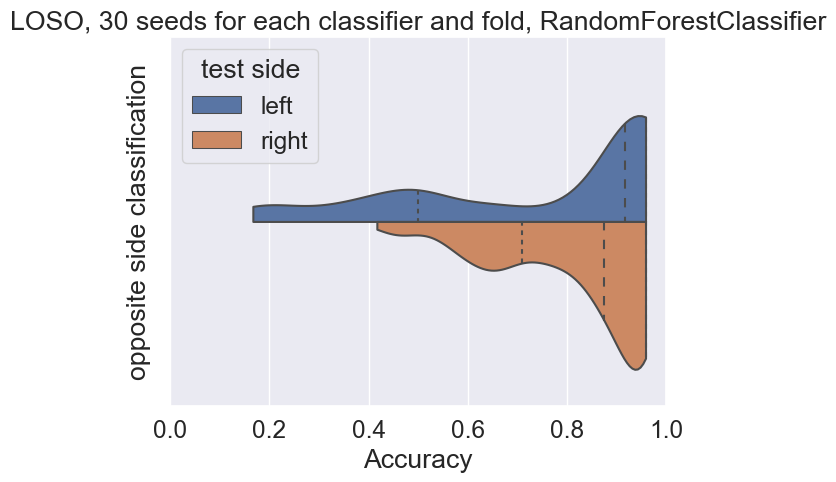

In [39]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

extra_col_name: str = 'opposite side classification'
data_to_plot = DataFrame([*selected_results_rxlx, *selected_results_lxrx], columns=[metrics_selected, "test side"])
data_to_plot[extra_col_name] = ""
ax = violinplot(data_to_plot, x=metrics_selected, y=extra_col_name, hue='test side', split=True, inner='quartile', cut=0)
plt.title(f"LOSO, {n_seeds_to_test_classifiers} seeds for each classifier and fold, {model_selected}")
ax.set_xlim(0., 1.0)
plt.show()

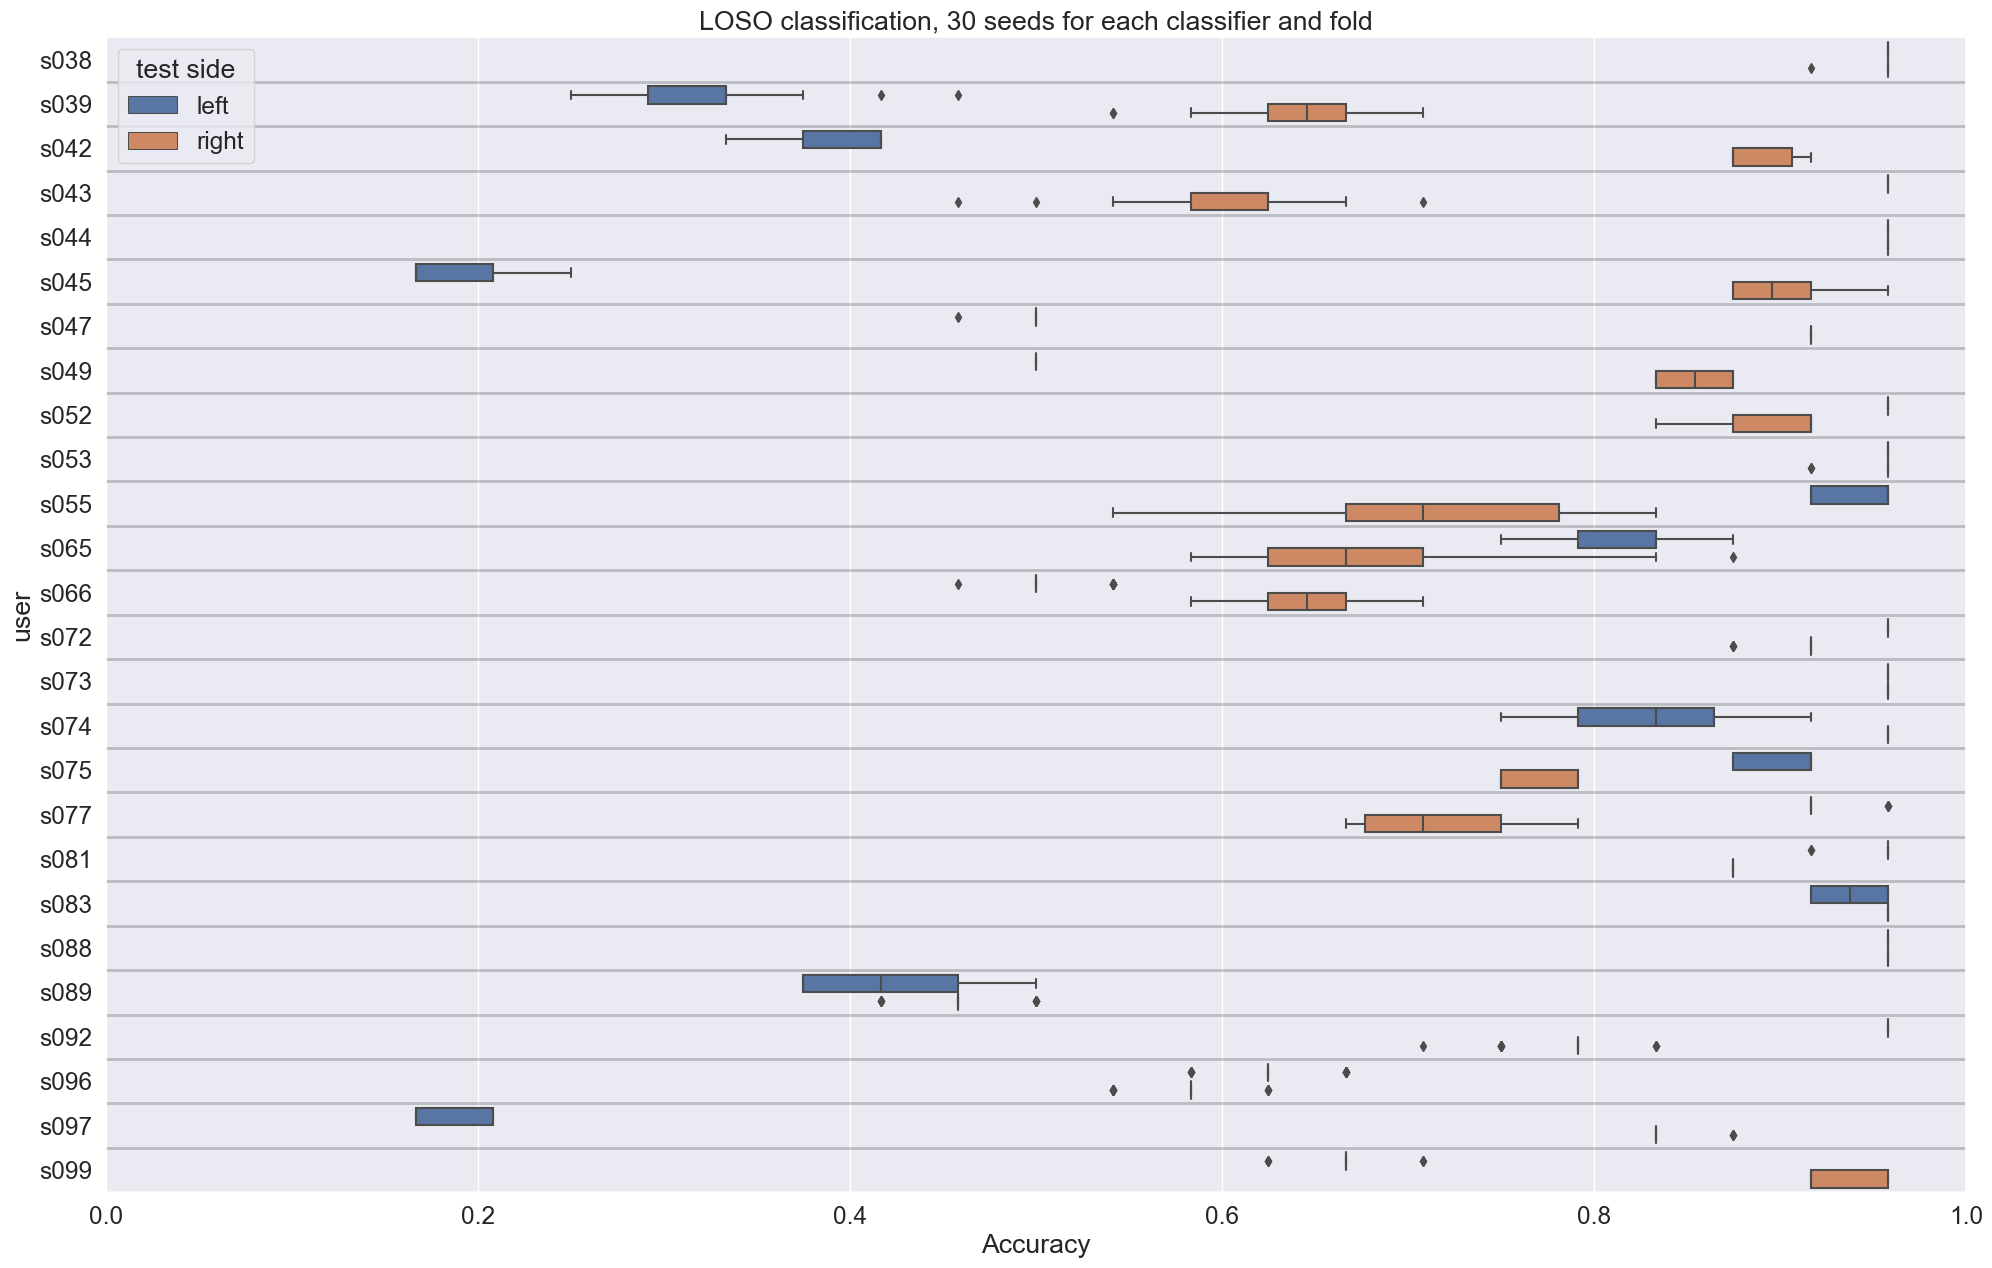

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", single_result.columns.name)
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", single_result.columns.name)
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

plt.figure(figsize=(24, 15))
sns.set_context("paper")
sns.set(font_scale=1.6)
data_to_plot = DataFrame([*selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "test side", "user"])
data_to_plot = data_to_plot.sort_values('user')
ax = sns.boxplot(data_to_plot, x=metrics_selected, y="user", hue='test side')
ax.xaxis.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
# ax.yaxis.grid(True, which='major', linestyle='-', linewidth=13, color='orange', alpha=0.3)
plt.title(f"LOSO classification, {n_seeds_to_test_classifiers} seeds for each classifier and fold")
ax.set_xlim(0., 1.0) 
plt.show()


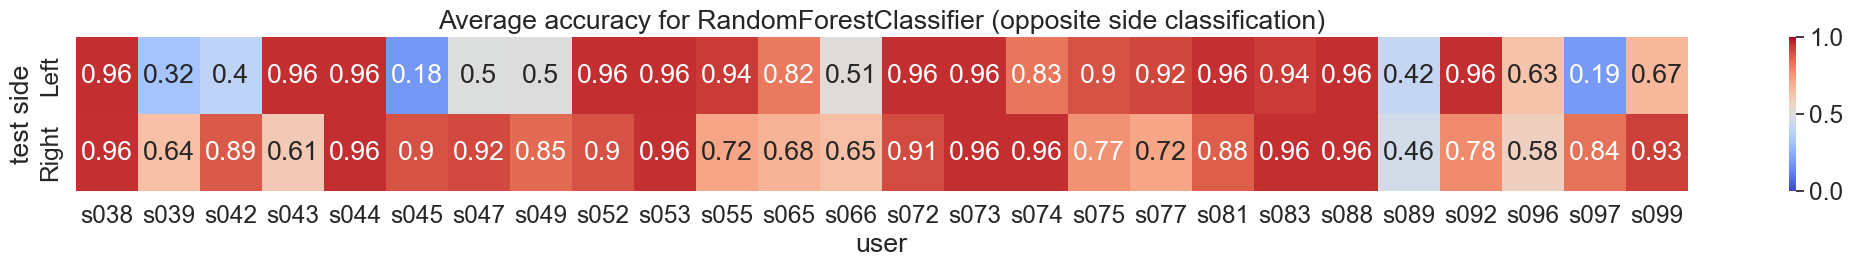

In [41]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
plt.figure(figsize=(len(data_to_plot2.columns), 2))
ax = sns.heatmap(data_to_plot2, 
            yticklabels=['Left', 'Right'],
            cmap='coolwarm', 
            annot=data_to_plot2.round(decimals=2),
            vmin=0, vmax=1,
            center=0.5,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy for {model_selected} (opposite side classification)")
plt.show()

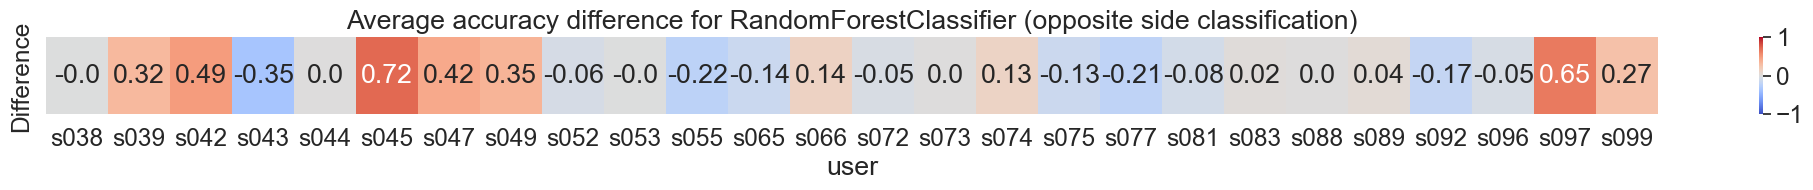

In [42]:
data_to_plot2 = data_to_plot.groupby(['user', 'test side']).mean().unstack(level=[0]).T
data_to_plot2.index = data_to_plot2.index.droplevel(0)
data_to_plot2 = data_to_plot2.T
data_to_plot3 = data_to_plot2.iloc[1,:] - data_to_plot2.iloc[0,:]
data_to_plot3 = DataFrame(data_to_plot3, columns=['Difference']).T

plt.figure(figsize=(len(data_to_plot3.columns),1))
ax = sns.heatmap(data_to_plot3, 
            yticklabels=['Difference'],
            cmap='coolwarm', 
            annot=data_to_plot3.round(decimals=2).values,
            vmin=-1, vmax=1,
            center=0,
            fmt="",)
plt.xticks(rotation=0, minor=True)
plt.title(f"Average accuracy difference for {model_selected} (opposite side classification)")
plt.show()

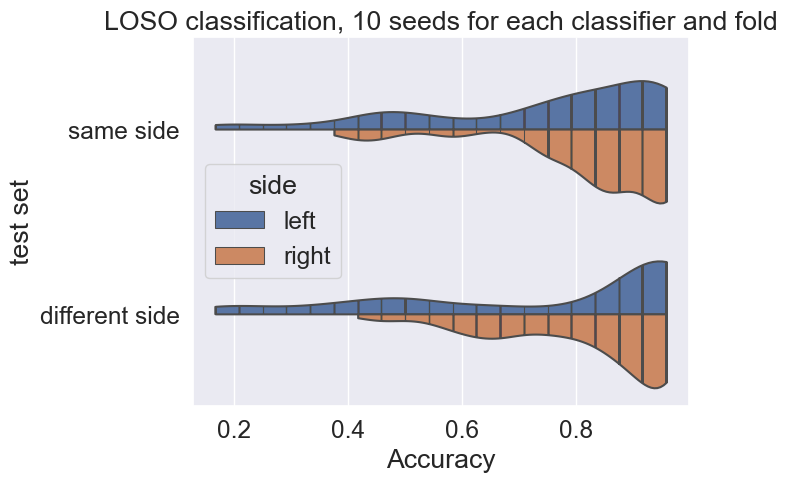

In [43]:
import matplotlib.pyplot as plt
from seaborn import violinplot

selected_results_rxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "same side")
    for seed_res in all_results_loso_rxrx
    for single_result in seed_res
]

selected_results_lxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "same side")
    for seed_res in all_results_loso_lxlx
    for single_result in seed_res
]

selected_results_lxrx = [
    (single_result.loc[model_selected, metrics_selected], "right", "different side")
    for seed_res in all_results_loso_lxrx
    for single_result in seed_res
]

selected_results_rxlx = [
    (single_result.loc[model_selected, metrics_selected], "left", "different side")
    for seed_res in all_results_loso_rxlx
    for single_result in seed_res
]

data_to_plot = DataFrame([*selected_results_lxlx, *selected_results_rxrx, *selected_results_lxrx, *selected_results_rxlx], columns=[metrics_selected, "side", "test set"])
ax = violinplot(data_to_plot, x=metrics_selected, y="test set", hue='side', split=True, inner='stick', cut=0)
plt.title("LOSO classification, 10 seeds for each classifier and fold")
# ax.set_xlim(0.5, 1.0)
plt.show()